In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program plots a per-event array (jet_pt) that has been masked to meet certain conditions (in this case, abs(jet eta) < 1).

class JetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        Jet_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 60)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, Jet_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        
        dataset = df["dataset"]
        
        # JaggedCandidateArray bundles together keys from the TTree dict into a TLorentzVector, as well as any amount of additional keys. To refer to a TLorentzVector property, use "JCA"['p4']."property" or "JCA"."property"; to refer to extra keys, "JCA"["property"]
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content,
            eta=df['Jet_eta'].content,
            phi=df['Jet_phi'].content,
            mass=df['Jet_mass'].content,
            )

        output['cutflow']['all events'] += jets.size
        output['cutflow']['number of jets'] += jets.counts.sum()
        
        # We want jets with an abs(eta) < 1. Conditionals act on every value in an array in Coffea, so this is easy. Note that we must give one conditional statement as a time. Something of the sort '1 < jets['p4'].eta < 1' WILL return an error! An alternative to below is ((jets['p4'].eta < 1) & (jets['p4'].eta > -1)), but this feels unnecessarily long when numpy can be used. Also, don't use 'and', use '&'!
        eta_max = (np.absolute(jets['p4'].eta) < 1)
        # eta_max is a Boolean array, with True in the place of values where the condition is met, and False otherwise. We want to sum up all the Trues (=1) in each sublist, then sum up all the sublists to get the number of jets with pt > 20.
        output['cutflow']['abs(eta) < 1'] += eta_max.sum().sum()
            
        # We define good_jets as the actual jets we want to graph. We mask it with the jets that have abs(eta) < 1.
        good_jets = jets[eta_max]
        # good_jets is no longer a Boolean array, so we can't just sum up the True's. We count the amount of jets and sum that.
        output['cutflow']['final good jets'] += good_jets.counts.sum()
        
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=good_jets['p4'].pt.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'Jets with pT > 20 and abs(eta) < 1': ["data/Run2012B_SingleMu.root"]}

output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=JetProcessor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4},
                                 chunksize = 500000)

Processing: 100%|██████████| 107/107 [00:58<00:00,  1.84items/s]


(<Figure size 432x288 with 1 Axes>,
 {<StringBin (Jets with pT > 20 and abs(eta) < 1) instance at 0x7f63d0ed07b8>: [<matplotlib.collections.PolyCollection at 0x7f636d0878d0>],
  'legend': <matplotlib.legend.Legend at 0x7f63d0edefd0>})

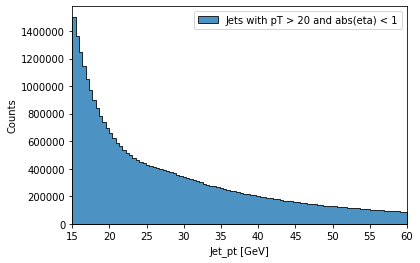

In [4]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
number of jets 170952895
abs(eta) < 1 39563735
final good jets 39563735
